Prueba predictor base para el modelo 

In [1]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.pyfunc
import dagshub
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
import subprocess

c:\Users\anaig\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
# Configurar DAGsHub con MLflow
dagshub.init(repo_owner='auditoria.SGBA1', repo_name='SGBA1-smartgrids', mlflow=True)
mlflow.set_tracking_uri("https://dagshub.com/auditoria.SGBA1/SGBA1-smartgrids.mlflow")
mlflow.set_experiment("Predicción Precio Luz con Prophet")

Accessing as auditoria.SGBA1

Initialized MLflow to track repo "auditoria.SGBA1/SGBA1-smartgrids"

Repository auditoria.SGBA1/SGBA1-smartgrids initialized!

<Experiment: artifact_location='mlflow-artifacts:/fd4a2e5b3f2c4b358051b572353ec8fa', creation_time=1740567102864, experiment_id='5', last_update_time=1740567102864, lifecycle_stage='active', name='Predicción Precio Luz con Prophet', tags={}>

In [3]:
# Cargar los datos
file_path = "../data/datos_completos_limpios.csv"  
df = pd.read_csv(file_path)

# Preparar los datos para Prophet
df['datetime'] = pd.to_datetime(df['datetime'])
df_prophet = df[['datetime', 'precio']].rename(columns={'datetime': 'ds', 'precio': 'y'})

# Definir el punto de corte para la validación (últimos 7 días)
split_date = df_prophet['ds'].max() - pd.Timedelta(days=7)
train = df_prophet[df_prophet['ds'] <= split_date]
test = df_prophet[df_prophet['ds'] > split_date]

- Prophet no es directamente compatible con `mlflow.pyfunc.log_model()`
- Requiere un objeto que herede de `mlflow.pyfunc.PythonModel`
- Creamos una clase para envolver el modelo Prophet y registrarlo en MLFlow 

In [4]:
# Clase personalizada para Prophet en MLflow
class ProphetWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, model):
        self.model = model

    def predict(self, context, model_input):
        model_input = pd.DataFrame(model_input)
        model_input.columns = ['ds']
        forecast = self.model.predict(model_input)
        return forecast[['ds', 'yhat']]

c:\Users\anaig\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\pyfunc\utils\data_validation.py:134: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


Guardamos el experimento y registramos el modelo

12:36:53 - cmdstanpy - INFO - Chain [1] start processing
12:36:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 19.81
Root Mean Squared Error (RMSE): 25.66


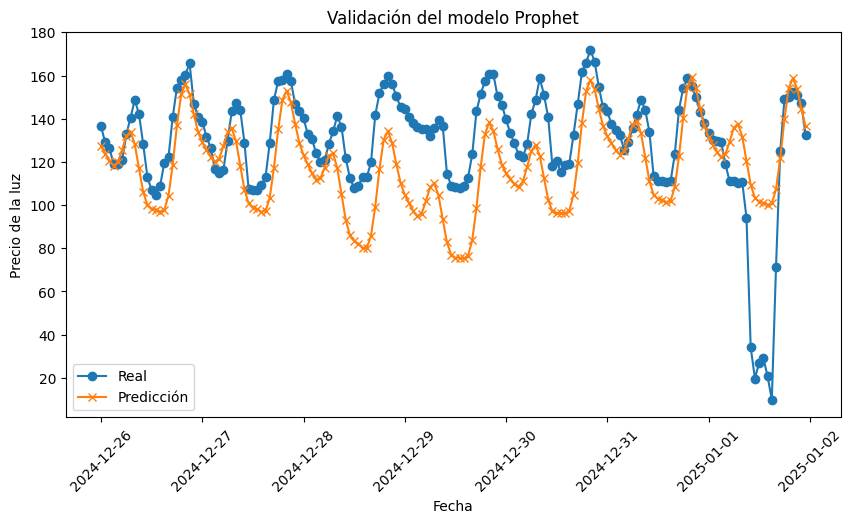

2025/02/26 12:37:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Prophet-Precio-Luz' already exists. Creating a new version of this model...
2025/02/26 12:37:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Prophet-Precio-Luz, version 3
Created version '3' of model 'Prophet-Precio-Luz'.


¡Modelo registrado en DAGsHub y MLflow correctamente con Run ID: 46f658dad3784fca80e81cfa22bf3412!
🏃 View run wistful-bat-273 at: https://dagshub.com/auditoria.SGBA1/SGBA1-smartgrids.mlflow/#/experiments/5/runs/46f658dad3784fca80e81cfa22bf3412
🧪 View experiment at: https://dagshub.com/auditoria.SGBA1/SGBA1-smartgrids.mlflow/#/experiments/5


In [5]:

# Iniciar experimento en MLflow
with mlflow.start_run() as run:
    run_id = run.info.run_id  # Guardamos el Run ID

    # Registrar parámetros
    mlflow.log_param("modelo", "Prophet")
    mlflow.log_param("periodo_validacion_dias", 7)

    # Obtener la versión actual del dataset en DVC y registrarla en MLflow
    dvc_status = subprocess.run(["dvc", "status"], capture_output=True, text=True).stdout
    mlflow.log_param("dvc_dataset_version", dvc_status)

    # Crear y ajustar el modelo Prophet
    model = Prophet()
    model.fit(train)

    # Hacer predicciones para el conjunto de validación
    future = test[['ds']]  # Usamos las fechas de prueba
    forecast = model.predict(future)

    # Evaluar el modelo
    y_true = test['y'].values
    y_pred = forecast['yhat'].values

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Registrar métricas en MLflow
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("RMSE", rmse)

    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

    # Graficar resultados
    plt.figure(figsize=(10, 5))
    plt.plot(test['ds'], y_true, label="Real", marker='o')
    plt.plot(test['ds'], y_pred, label="Predicción", marker='x')
    plt.legend()
    plt.title("Validación del modelo Prophet")
    plt.xlabel("Fecha")
    plt.ylabel("Precio de la luz")
    plt.xticks(rotation=45)

    # Guardar la gráfica y subirla a MLflow
    plt.savefig("validacion_prediccion.png")
    mlflow.log_artifact("validacion_prediccion.png")
    plt.show()

    # Guardar el modelo Prophet como un archivo pickle
    model_path = "prophet_model.pkl"
    with open(model_path, "wb") as f:
        pickle.dump(model, f)

    # Registrar el modelo en MLflow usando la clase personalizada
    model_name = "Prophet-Precio-Luz"
    model_uri = f"runs:/{run_id}/prophet_model"

    mlflow.pyfunc.log_model(artifact_path="prophet_model", python_model=ProphetWrapper(model))

    # Registrar el modelo en MLflow Model Registry
    mlflow.register_model(model_uri=model_uri, name=model_name)

    print(f"¡Modelo registrado en DAGsHub y MLflow correctamente con Run ID: {run_id}!")

Borrar los otros modelos